In [1]:
import pickle

from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = "../data/datasets/tfidf/"
df = pd.read_csv('../data/datasets/contents.csv', dtype={'Category': 'category'})

with open(DATA_PATH+'features_train.pickle', 'rb') as data:
    features_train = pickle.load(data)

with open(DATA_PATH+'labels_train.pickle', 'rb') as data:
    labels_train = pickle.load(data)

with open(DATA_PATH+'features_test.pickle', 'rb') as data:
    features_test = pickle.load(data)

with open(DATA_PATH+'labels_test.pickle', 'rb') as data:
    labels_test = pickle.load(data)

In [7]:
features_train = features_train[:10_000]
labels_train = labels_train[:10_000]

In [8]:
rf_0 = RandomForestClassifier(random_state=0)

pprint(rf_0.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [9]:
# Random Search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [10]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [11]:
print("The best hyperparameters from Grid Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)
best_rfc = random_search.best_estimator_

The best hyperparameters from Grid Search are:
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.7092012740566198


In [12]:
# FIT 
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(max_depth=60, min_samples_leaf=2, n_estimators=600,
                       random_state=8)

In [13]:
rfc_pred = best_rfc.predict(features_test)

In [14]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.879


In [15]:
# Test accuracy
# 0.937
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.7117555555555556


In [16]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.72      0.75      0.74     20048
           1       0.70      0.81      0.75     20732
           2       0.64      0.05      0.09      4220

    accuracy                           0.71     45000
   macro avg       0.69      0.54      0.53     45000
weighted avg       0.71      0.71      0.68     45000



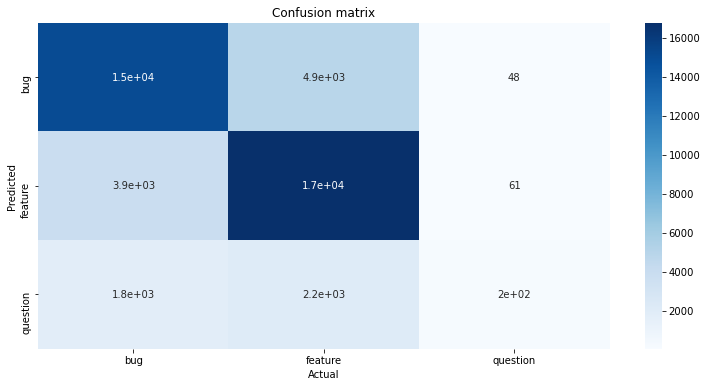

In [17]:
aux_df = pd.DataFrame([['bug', 0], ['feature', 1], ['question', 2]], columns=['Category', 'Category_Code'])


conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [18]:
# Default parameters RF
# Acc: 0.934
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.7089777777777778

In [19]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [20]:
with open('../models/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open('../models/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)